In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from apyori import apriori

## 1. Diagnoses

The combined d_diagnoses table:
- ICD9 CODE - Code relating to the diagnosis
- Short and long title description


In [2]:
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
d_diagnoses = pd.read_csv('D_ICD_DIAGNOSES.csv')

# combine the two tables, based on ICD9_CODE, without short title
df_diag = pd.merge(diagnoses, d_diagnoses, on='ICD9_CODE', how='inner')
df_diag = df_diag.dropna(subset=['ICD9_CODE'])
df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'].astype(str)

In [3]:
mismatched_codes = diagnoses.loc[~diagnoses['ICD9_CODE'].isin(d_diagnoses['ICD9_CODE']), 'ICD9_CODE']
print("Mismatched codes:", mismatched_codes.unique())


Mismatched codes: ['7895' '2765' '5118' '7793' '5185' '2848' '9973' '2740' '7775' 'V461'
 '4538' '6000' '7806' '4440' '2766' 'V721' '3488' 'V174' '5191' '5968'
 '9974' '7708' '2841' '0414' '2880' '9998' '5672' '2554' '4251' 'V451'
 '2874' '5997' '7872' '7662' '4582' '2387' '7931' '9983' '7863' '9980'
 '9708' '9964' '585' '7299' '7809' '3238' '3236' '7473' nan '6951' '4781'
 '2520' '9697' '7070' '8501' '3483' 'E927' '5163' '5302' 'V155' 'E888'
 '7990' 'V854' '2773' 'V122' 'V644' '5280' '2750' '6180' '5678' '2873'
 'V017' '7718' '3578' '9690' 'V581' '5128' '9993' '7701' '5996' '7845'
 '1733' '1730' 'V152' '3370' '1732' '5888' '7955' '7876' 'V138' 'V610'
 '7671' '7798' '2865' '5233' '1737' '2824' 'V608' '2898' 'V51' '4881'
 'V135' '2794' '3580' '9995' '7758' '1736' '9952' '6082' '2333' '2840'
 '5640' '6118' '3592' 'V583' '7902' '1735' '6188' '5234' '3337' '7721'
 '1734' '2778' '6213' '1739' '7583' '6002' 'V403' '9996' '71970' '6009'
 'V640' '7992' '6168' '6221' '3234' 'V181' 'V109' '7687'

156192

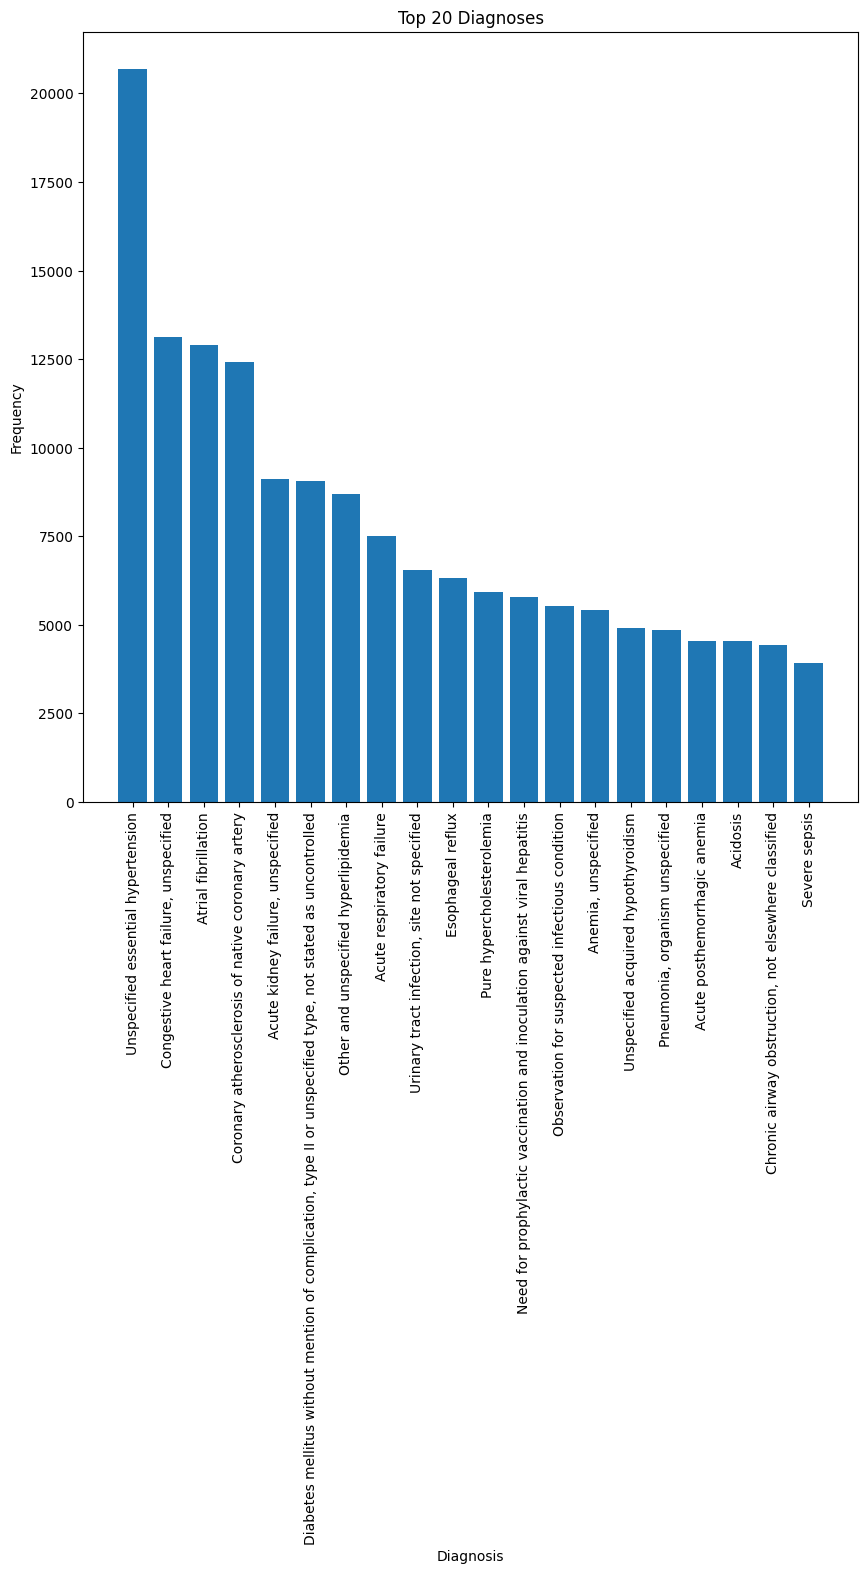

In [73]:
# create histogram of the top 20 diagnoses
top20_diag = df['LONG_TITLE'].value_counts().head(20)

plt.figure(figsize=(10,10))
plt.title('Top 20 Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.bar(top20_diag.index, top20_diag.values)
plt.xticks(rotation=90)

sum(top20_diag.values)

In [74]:
# create list of list for each patient diagnosis
diag_list = df_diag.groupby('HADM_ID')['ICD9_CODE'].apply(list).values.tolist()

### Using Association Rule Mining for Diagnosis

Association rule mining is used to identify pattens in large datasets, and in this case where the number of diagnosis is very sparse with close to 6000 unique ICD CODEs and diagnosis, we can identify what diagnosis are commonly found with one another, grouped by HADM ID.

We can use several association rule mining techniques and algorithms.

The Apriori algorithm identifies the frequent itemsets (in this case the diagnosis sets), and generates association rules, like "if patient has kidney disease, then they are likely to get UTIs".

Support tells us the proportion of patients that have for example, septic shock and severe sepsis
Confidence tells us what the likelihood is of severe sepsis given septic shock (Among the patients with septic shock, 93% have severe sepsis)
Lift is how much more likely a patient will get severe sepsis, if we know that they have septic shock, compared to not knowing anything.

In [75]:
# to string
for i in range(0, len(diag_list)):
    diag_list[i] = [str(x) for x in diag_list[i]]


In [76]:
# map ICD9_CODE to LONG_TITLE and also the short title for dictionary lookup
icd9_to_title = dict(zip(df['ICD9_CODE'], df['LONG_TITLE']))
icd9_to_shorttitle = dict(zip(df['ICD9_CODE'], df['SHORT_TITLE']))

In [78]:
# tables used: diagnoses_icd and d_icd_diagnoses

def assoc_results(association_results): 
    df = []
    for item in association_results:
        rule = []
        pair = item[0] 
        items = [x for x in pair]
        rule.append(f"{icd9_to_shorttitle[items[0]]} -> {icd9_to_shorttitle[items[1]]}")
        rule.append(icd9_to_title[items[0]])
        rule.append(icd9_to_title[items[1]])
        rule.append(item[1])
        rule.append(item[2][0][2])
        rule.append(item[2][0][3])
        df.append(rule)
    return df

association_rules = apriori(diag_list, min_support=0.02, min_confidence=0.7, min_lift=3, min_length=3)
association_results = list(association_rules)
rules = pd.DataFrame(assoc_results(association_results), columns=['Rule','x1','x2' ,'Support', 'Confidence', 'Lift'])
rules.sort_values(by='Lift', ascending=False)

,Rule,x1,x2,Support,Confidence,Lift
1,End stage renal disease -> Hyp kid NOS w cr kid V,End stage renal disease,"Hypertensive chronic kidney disease, unspecifi...",0.024641,0.753894,16.890954
3,Aortocoronary bypass -> Cor ath unsp vsl ntv/gft,Aortocoronary bypass status,Coronary atherosclerosis of unspecified type o...,0.021146,0.834003,16.081023
13,Septic shock -> Severe sepsis,Septic shock,Severe sepsis,0.025117,0.940877,14.172085
7,Septic shock -> Severe sepsis,Septic shock,Severe sepsis,0.040950,0.933101,14.054958
15,Hy kid NOS w cr kid I-IV -> Chronic kidney dis...,"Hypertensive chronic kidney disease, unspecifi...","Chronic kidney disease, unspecified",0.021366,0.717788,12.363535
0,Hy kid NOS w cr kid I-IV -> Chronic kidney dis...,"Hypertensive chronic kidney disease, unspecifi...","Chronic kidney disease, unspecified",0.041188,0.709442,12.169971
11,Need prphyl vc vrl hepat -> Routine circumcision,Need for prophylactic vaccination and inoculat...,Routine or ritual circumcision,0.029648,0.866567,8.835869
9,Need prphyl vc vrl hepat -> Single lb in-hosp ...,Need for prophylactic vaccination and inoculat...,"Single liveborn, born in hospital, delivered w...",0.049419,0.816601,8.326393
17,Need prphyl vc vrl hepat -> NB obsrv suspct in...,Need for prophylactic vaccination and inoculat...,Observation for suspected infectious condition,0.037997,0.768887,8.209220
12,NB obsrv suspct infect -> Single lb in-hosp w/...,Observation for suspected infectious condition,"Single liveborn, born in hospital, delivered w...",0.045719,0.755468,8.065949


### 2. Procedures:

The following data table explored consists of the following:
- IC9_CODE - Relating to the procedure involved
- Short and Long title - Relating to the decription of the procedure

79510

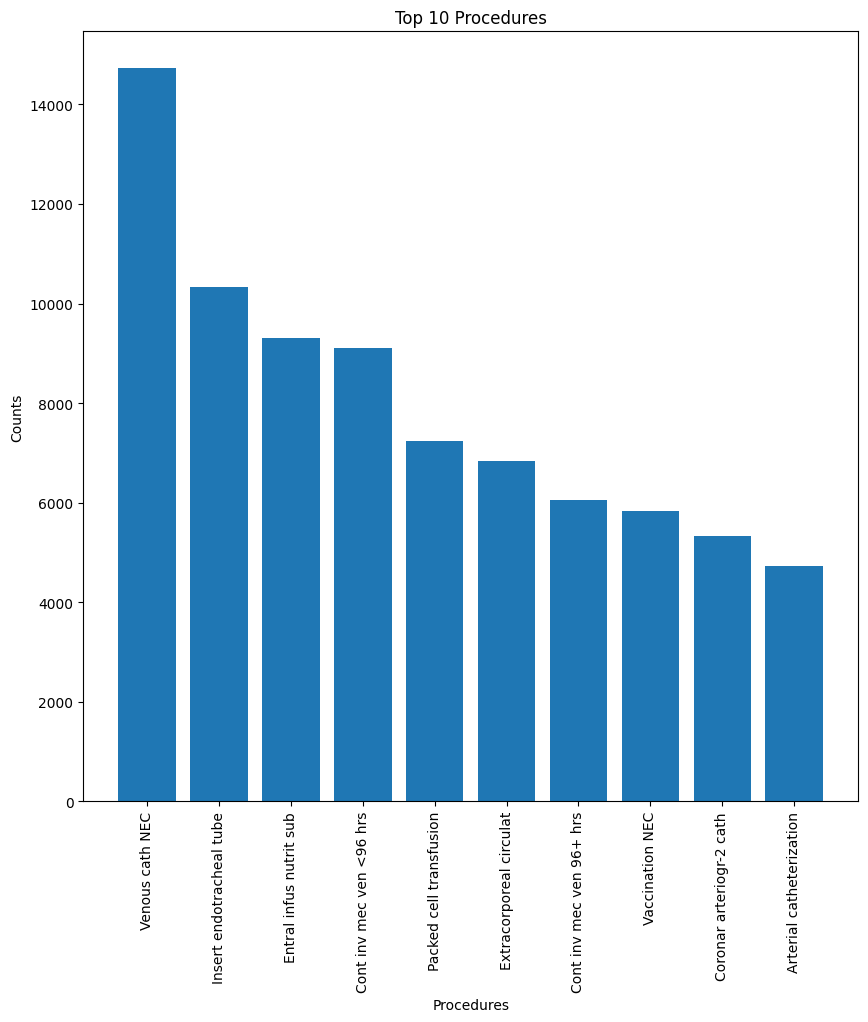

In [5]:
proceds = pd.read_csv('PROCEDURES_ICD.csv')
d_proceds = pd.read_csv('D_ICD_PROCEDURES.csv')

df_proceds = pd.merge(proceds, d_proceds, on='ICD9_CODE', how='inner') # combine the two tables, based on ICD9_CODE
df_proceds['ICD9_CODE'] = df_proceds['ICD9_CODE'].astype(str) #change type of icd9 code to string

# create histogram of the top 10 procedures
top10_proceds = df_proceds['SHORT_TITLE'].value_counts().head(10)
plt.figure(figsize=(10,10))
plt.title('Top 10 Procedures')
plt.xlabel('Procedures')
plt.ylabel('Counts')
plt.bar(top10_proceds.index, top10_proceds.values)
plt.xticks(rotation=90)

sum(top10_proceds.values)

In [89]:
# combine the two tables, based on ICD9_CODE, without short title
df_proceds_diag = pd.merge(df_proceds, df_diag, on=['HADM_ID'], how='left')
df_proceds_diag

,ROW_ID_x_x,SUBJECT_ID_x,HADM_ID,SEQ_NUM_x,ICD9_CODE_x,ROW_ID_y_x,SHORT_TITLE_x,LONG_TITLE_x,ROW_ID_x_y,SUBJECT_ID_y,SEQ_NUM_y,ICD9_CODE_y,ROW_ID_y_y,SHORT_TITLE_y,LONG_TITLE_y
0,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483158.0,62641.0,2.0,9971,12365.0,Surg compl-heart,"Cardiac complications, not elsewhere classified"
1,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483159.0,62641.0,3.0,42731,4462.0,Atrial fibrillation,Atrial fibrillation
2,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483161.0,62641.0,5.0,5121,5152.0,Iatrogenic pneumothorax,Iatrogenic pneumothorax
3,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483157.0,62641.0,1.0,1623,1322.0,Mal neo upper lobe lung,"Malignant neoplasm of upper lobe, bronchus or ..."
4,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483164.0,62641.0,8.0,V1051,13329.0,Hx of bladder malignancy,Personal history of malignant neoplasm of bladder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167188,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382737.0,40811.0,2.0,5121,5152.0,Iatrogenic pneumothorax,Iatrogenic pneumothorax
3167189,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382736.0,40811.0,1.0,1570,1236.0,Mal neo pancreas head,Malignant neoplasm of head of pancreas
3167190,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382745.0,40811.0,10.0,3899,4543.0,Hearing loss NOS,Unspecified hearing loss
3167191,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382738.0,40811.0,3.0,1962,2055.0,Mal neo lymph intra-abd,Secondary and unspecified malignant neoplasm o...


In [66]:
len(df_diag['SHORT_TITLE'].unique())

6770

In [59]:
df_proceds[df_proceds['HADM_ID'] == 154460]

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
0,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage
183216,942,62641,154460,1,326,601,Rad dissec thorac struct,Radical dissection of thoracic structures
183221,943,62641,154460,2,3348,477,Bronchial repair NEC,Other repair and plastic operations on bronchus


In [60]:
df_diag[df_diag['HADM_ID'] == 154460]

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
198412,483158,62641,154460,2.0,9971,12365,Surg compl-heart,"Cardiac complications, not elsewhere classified"
214734,483159,62641,154460,3.0,42731,4462,Atrial fibrillation,Atrial fibrillation
344912,483161,62641,154460,5.0,5121,5152,Iatrogenic pneumothorax,Iatrogenic pneumothorax
348488,483157,62641,154460,1.0,1623,1322,Mal neo upper lobe lung,"Malignant neoplasm of upper lobe, bronchus or ..."
394524,483164,62641,154460,8.0,V1051,13329,Hx of bladder malignancy,Personal history of malignant neoplasm of bladder
453163,483163,62641,154460,7.0,45182,4289,Phlbts sprfc vn up extrm,Phlebitis and thrombophlebitis of superficial ...
487761,483160,62641,154460,4.0,99679,12342,Comp-int prost devic NEC,Other complications due to other internal pros...
610338,483162,62641,154460,6.0,99791,12380,Surg comp - hypertension,Complications affecting other specified body s...


In [61]:
df_proceds_diag[df_proceds_diag['HADM_ID'] == 154460]

,ROW_ID_x_x,SUBJECT_ID_x,HADM_ID,SEQ_NUM_x,ICD9_CODE_x,ROW_ID_y_x,SHORT_TITLE_x,LONG_TITLE_x,ROW_ID_x_y,SUBJECT_ID_y,SEQ_NUM_y,ICD9_CODE_y,ROW_ID_y_y,SHORT_TITLE_y,LONG_TITLE_y
0,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483158.0,62641.0,2.0,9971,12365.0,Surg compl-heart,"Cardiac complications, not elsewhere classified"
1,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483159.0,62641.0,3.0,42731,4462.0,Atrial fibrillation,Atrial fibrillation
2,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483161.0,62641.0,5.0,5121,5152.0,Iatrogenic pneumothorax,Iatrogenic pneumothorax
3,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483157.0,62641.0,1.0,1623,1322.0,Mal neo upper lobe lung,"Malignant neoplasm of upper lobe, bronchus or ..."
4,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483164.0,62641.0,8.0,V1051,13329.0,Hx of bladder malignancy,Personal history of malignant neoplasm of bladder
5,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483163.0,62641.0,7.0,45182,4289.0,Phlbts sprfc vn up extrm,Phlebitis and thrombophlebitis of superficial ...
6,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483160.0,62641.0,4.0,99679,12342.0,Comp-int prost devic NEC,Other complications due to other internal pros...
7,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483162.0,62641.0,6.0,99791,12380.0,Surg comp - hypertension,Complications affecting other specified body s...
2324967,942,62641,154460,1,326,601,Rad dissec thorac struct,Radical dissection of thoracic structures,483158.0,62641.0,2.0,9971,12365.0,Surg compl-heart,"Cardiac complications, not elsewhere classified"
2324968,942,62641,154460,1,326,601,Rad dissec thorac struct,Radical dissection of thoracic structures,483159.0,62641.0,3.0,42731,4462.0,Atrial fibrillation,Atrial fibrillation


In [21]:
d_proceds

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,264,851,Canthotomy,Canthotomy
1,265,852,Blepharorrhaphy,Blepharorrhaphy
2,266,859,Adjust lid position NEC,Other adjustment of lid position
3,267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...
...,...,...,...,...
3877,3344,9959,Vaccination/innocula NEC,Other vaccination and inoculation
3878,3345,9960,Cardiopulm resuscita NOS,"Cardiopulmonary resuscitation, not otherwise s..."
3879,3346,9961,Atrial cardioversion,Atrial cardioversion
3880,3347,9962,Heart countershock NEC,Other electric countershock of heart


# Table Feature Selection:
## 1. Admissions: - Joined on HADM ID
- Admission Type

## 2. Callout: (Potential Omission)
Subject calls for assistance of medical intervention, may be important as the patient can feel if something is wrong. However, does not give us much information about the hospital admission itself but we can deduce the callout service and curr_careunit?

Might be tricky because one HADM ID can have multiple ward IDS, or care units, meaning that they might be shifted from a ward to another ward.

Perhaps, it is easier to just determine if they have been in a ICU or not (1 or 0)

## 3. Caregivers: (Potential Omission)
Might not tell us much - my guess and opinion is that it is not an incredibly important table. Potential omission.

## 4. Current Procedural Terminology (CPT) Events, possibly combined with D_CPT
Not entirely sure what this table is, but it looks like it tells us how the admission was handled.
Pulmonary/Hospital Impatient Services/Consulations/...

## 5. Date Time Events
Details what ITEM_ID (D_ITEMS) that was charted at what time.

## 6. Diagnoses
The diagnoses that the patient, HADM ID was diagnosed with, called from the table D_DIAGNOSES with long and short titles. Joined using the ICD9 code, and can have multiple diagnoses

## 7. Procedures 
Similar to Diagnoses, called from the D_PROCEDURES table, with long and short titles, joined by ICD9 codes and can have multiple diagnoses. 

## 8. Input CV: (Cont. Variable)
Tells us the drug and amount administered, linked to D_ITEMS, and linked to ICU and HADM also.

## 9. Input MV (Discrete)
Information about medications and fluids administered through intermittent or bolus IV injections. Unlike the continuous infusions in "INPUTEVENTS_CV," these are typically single or discrete events, similarly linked to the Item table and ICU HDAM

## 10, Lab Events
Contains records of laboratory test results performed on ICU patients. These tests cover a wide range of clinical parameters, including blood tests, chemistry panels, hematology, and various other diagnostic tests.
The FLAG is the important bit, as well as the ItemID test, which tells us if there is abnormal results

## 11. Microbiology
Contains information related to microbiology culture results obtained from ICU patients. It includes details about the organisms detected and their susceptibilities to antibiotics.
Specific Item ID relates to which test and name of the organism detected in (org_name)

## 12. Note Events
Contains freetext about what the staff has noted. perhaps not incredibly important

## 13. Output Events
Contains records of various output events, such as urine output, gastrointestinal output (e.g., stool), and other fluid measurements. These events are important for assessing a patient's fluid balance and renal function.
Item ID identifies what the specific output was and the value. 

## 14. Patient
Just the identifier, with gender, and DOB, can link to admissions using subject ID

## 15. Prescription
Contains records of medications that were prescribed to ICU patients during their hospital stays, about which drugs and dose and route. Can link to ICU or HADM

## 16. Prod Events
Contains records of medical procedures and interventions performed on ICU patients. These procedures can include surgeries, diagnostic tests, and therapeutic interventions. Item ID specifies what procedure done, and where it was done

## 17. ICU Stays 
Determine the ICU ID and the length of stay, as well as what ward it was held in.

## Tasks to complete

Data Cleaning and Feature Selection
- Merge tables admissions and patients
- Merge the tables that uses D ITEMS
- Try to find more relationships between procedures and diagnoses

Think about how to put patients that have multiple tests or procedures into a single row per patient. 
Additonally, think about how to extract any diagnoses that have UTIs, can always change the model after. 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Finding the Relationships with UTI

We noted earlier that using the Apiori Association Rule Mining algorithm, we could find some of the top associations between diagnoses, which gives us a better understanding to what diagnoses can be related to each other. To narrow down our search, we might only want patients that have UTIs as a diagnoses. We can verify that the 2 Urinary Tract Infection ICD Codes are:

- 5990: Urinary tract infection, site not specified
- 77182: Urinary tract infection of newborn

Apart from finding UTIs, we can try other diagnoses like Atrial Fib, Hypertension, Heart Disease or any of the more common diagnoses that we have found in the chart.

In [67]:
# First, we look for the ICD Codes that have UTI from the d_diagnoses table

utis = d_diagnoses[d_diagnoses['LONG_TITLE'].str.contains('Urinary') & d_diagnoses['LONG_TITLE'].str.contains('infection')]['ICD9_CODE'].values # for urinary infection
any_urinary = d_diagnoses[d_diagnoses['LONG_TITLE'].str.contains('Urinary')]['ICD9_CODE'].values # any urinary condition/complications

In [83]:
# preprocessing for apriori algorithm
diag_list = df_diag.groupby('HADM_ID')['ICD9_CODE'].apply(list).values.tolist()

# select list of patients with UTI
utis_list = [x for x in diag_list if x in any_urinary]


/var/folders/_6/0wh_fbl90xz8m8df6c8q_5dc0000gn/T/ipykernel_81913/1022137871.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  utis_list = [x for x in diag_list if x in any_urinary]


In [90]:
# map ICD9_CODE to LONG_TITLE and also the short title for dictionary lookup
icd9_to_title = dict(zip(df_diag['ICD9_CODE'], df_diag['LONG_TITLE']))
icd9_to_shorttitle = dict(zip(df_diag['ICD9_CODE'], df_diag['SHORT_TITLE']))

In [87]:
def assoc_results(association_results): 
    df = []
    for item in association_results:
        rule = []
        pair = item[0] 
        items = [x for x in pair]
        rule.append(f"{icd9_to_shorttitle[items[0]]} -> {icd9_to_shorttitle[items[1]]}")
        rule.append(icd9_to_title[items[0]])
        rule.append(icd9_to_title[items[1]])
        rule.append(item[1])
        rule.append(item[2][0][2])
        rule.append(item[2][0][3])
        df.append(rule)
    return df

In [100]:
association_rules = apriori(utis_list, min_support=0.02, min_confidence=0.7, min_lift=3, min_length=2)
association_results = list(association_rules)
rules = pd.DataFrame(assoc_results(association_results), columns=['Rule','x1','x2' ,'Support', 'Confidence', 'Lift'])
rules.sort_values(by='Lift', ascending=False)

,Rule,x1,x2,Support,Confidence,Lift
445,Surg compl-heart -> Hypertension NOS,"Cardiac complications, not elsewhere classified",Unspecified essential hypertension,0.027027,1.0,37.000000
366,Hypothyroidism NOS -> Hypertension NOS,Unspecified acquired hypothyroidism,Unspecified essential hypertension,0.027027,1.0,37.000000
97,Neuropathy in diabetes -> Hypertension NOS,Polyneuropathy in diabetes,Unspecified essential hypertension,0.027027,1.0,37.000000
260,Urin tract infection NOS -> Neuropathy in diab...,"Urinary tract infection, site not specified",Polyneuropathy in diabetes,0.027027,1.0,37.000000
244,Status-post ptca -> DMII wo cmp nt st uncntr,Percutaneous transluminal coronary angioplasty...,Diabetes mellitus without mention of complicat...,0.027027,1.0,37.000000
...,...,...,...,...,...,...
195,Chronic liver dis NEC -> Urin tract infection NOS,Other chronic nonalcoholic liver disease,"Urinary tract infection, site not specified",0.027027,1.0,3.083333
196,Urin tract infection NOS -> Hypoxemia,"Urinary tract infection, site not specified",Hypoxemia,0.027027,1.0,3.083333
342,Urin tract infection NOS -> Crnry athrscl natv...,"Urinary tract infection, site not specified",Coronary atherosclerosis of native coronary ar...,0.040541,1.0,3.083333
341,CHF NOS -> Crnry athrscl natve vssl,"Congestive heart failure, unspecified",Coronary atherosclerosis of native coronary ar...,0.027027,1.0,3.083333


In [101]:
rules[rules['x2'].str.contains('Urinary')].sort_values(by='Lift', ascending=False).head(10)

,Rule,x1,x2,Support,Confidence,Lift
307,Status-post ptca -> Urin tract infection NOS,Percutaneous transluminal coronary angioplasty...,"Urinary tract infection, site not specified",0.027027,1.0,37.000000
405,Surg compl-heart -> Urin tract infection NOS,"Cardiac complications, not elsewhere classified","Urinary tract infection, site not specified",0.027027,1.0,24.666667
402,Atrial fibrillation -> Urin tract infection NOS,Atrial fibrillation,"Urinary tract infection, site not specified",0.027027,1.0,24.666667
364,Pseudomonas infect NOS -> Urin tract infection...,Pseudomonas infection in conditions classified...,"Urinary tract infection, site not specified",0.027027,1.0,24.666667
241,Acute kidney failure NOS -> Urin tract infecti...,"Acute kidney failure, unspecified","Urinary tract infection, site not specified",0.027027,1.0,24.666667
206,E coli septicemia -> Urin tract infection NOS,Septicemia due to escherichia coli [E. coli],"Urinary tract infection, site not specified",0.027027,1.0,18.500000
362,Acute kidney failure NOS -> Urin tract infecti...,"Acute kidney failure, unspecified","Urinary tract infection, site not specified",0.027027,1.0,18.500000
338,Ac diastolic hrt failure -> Urin tract infecti...,Acute diastolic heart failure,"Urinary tract infection, site not specified",0.027027,1.0,18.500000
317,Septic shock -> Urin tract infection NOS,Septic shock,"Urinary tract infection, site not specified",0.027027,1.0,18.500000
216,Acute kidney failure NOS -> Urin tract infecti...,"Acute kidney failure, unspecified","Urinary tract infection, site not specified",0.027027,1.0,18.500000


In [102]:
rules[rules['x1'].str.contains('Urinary')].sort_values(by='Lift', ascending=False).head(10)

,Rule,x1,x2,Support,Confidence,Lift
152,Urin tract infection NOS -> Alzheimer's disease,"Urinary tract infection, site not specified",Alzheimer's disease,0.027027,1.0,37.000000
260,Urin tract infection NOS -> Neuropathy in diab...,"Urinary tract infection, site not specified",Polyneuropathy in diabetes,0.027027,1.0,37.000000
98,Urin tract infection NOS -> Neuropathy in diab...,"Urinary tract infection, site not specified",Polyneuropathy in diabetes,0.027027,1.0,37.000000
313,"Urin tract infection NOS -> Pneumonia, organis...","Urinary tract infection, site not specified","Pneumonia, organism unspecified",0.027027,1.0,24.666667
245,Urin tract infection NOS -> DMII wo cmp nt st ...,"Urinary tract infection, site not specified",Diabetes mellitus without mention of complicat...,0.027027,1.0,24.666667
360,Urin tract infection NOS -> Surg compl-heart,"Urinary tract infection, site not specified","Cardiac complications, not elsewhere classified",0.027027,1.0,24.666667
355,Urin tract infection NOS -> Surg compl-heart,"Urinary tract infection, site not specified","Cardiac complications, not elsewhere classified",0.027027,1.0,24.666667
288,Urin tract infection NOS -> Pure hypercholeste...,"Urinary tract infection, site not specified",Pure hypercholesterolemia,0.027027,1.0,24.666667
203,Urin tract infection NOS -> Surg compl-heart,"Urinary tract infection, site not specified","Cardiac complications, not elsewhere classified",0.027027,1.0,24.666667
361,"Urin tract infection NOS -> Ac kidny fail, tub...","Urinary tract infection, site not specified",Acute kidney failure with lesion of tubular ne...,0.027027,1.0,18.500000


Here are some of the UTIs and other diagnoses relatioships between those patients. However, it is important to consider that even though a patient has both of these diagnoses, one might not necesarily be directly associated/lead/account to the other. There are many other underlying factors that can lead to a particular diagnosis, so care has to be taken when accessing these relationships, specifically needing an expert opinion. 

In [2]:
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
d_diagnoses = pd.read_csv('D_ICD_DIAGNOSES.csv')

# combine the two tables, based on ICD9_CODE, without short title
df_diag = pd.merge(diagnoses, d_diagnoses, on='ICD9_CODE', how='inner')
df_diag = df_diag.dropna(subset=['ICD9_CODE'])
df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'].astype(str)

In [3]:
proceds = pd.read_csv('PROCEDURES_ICD.csv')
d_proceds = pd.read_csv('D_ICD_PROCEDURES.csv')

df_proceds = pd.merge(proceds, d_proceds, on='ICD9_CODE', how='inner') # combine the two tables, based on ICD9_CODE
df_proceds['ICD9_CODE'] = df_proceds['ICD9_CODE'].astype(str) #change type of icd9 code to string

# combine the two tables, based on ICD9_CODE, without short title
df_proceds_diag = pd.merge(df_proceds, df_diag, on=['HADM_ID'], how='left')
df_proceds_diag

,ROW_ID_x_x,SUBJECT_ID_x,HADM_ID,SEQ_NUM_x,ICD9_CODE_x,ROW_ID_y_x,SHORT_TITLE_x,LONG_TITLE_x,ROW_ID_x_y,SUBJECT_ID_y,SEQ_NUM_y,ICD9_CODE_y,ROW_ID_y_y,SHORT_TITLE_y,LONG_TITLE_y
0,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483158.0,62641.0,2.0,9971,12365.0,Surg compl-heart,"Cardiac complications, not elsewhere classified"
1,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483159.0,62641.0,3.0,42731,4462.0,Atrial fibrillation,Atrial fibrillation
2,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483161.0,62641.0,5.0,5121,5152.0,Iatrogenic pneumothorax,Iatrogenic pneumothorax
3,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483157.0,62641.0,1.0,1623,1322.0,Mal neo upper lobe lung,"Malignant neoplasm of upper lobe, bronchus or ..."
4,944,62641,154460,3,3404,496,Insert intercostal cath,Insertion of intercostal catheter for drainage,483164.0,62641.0,8.0,V1051,13329.0,Hx of bladder malignancy,Personal history of malignant neoplasm of bladder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167188,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382737.0,40811.0,2.0,5121,5152.0,Iatrogenic pneumothorax,Iatrogenic pneumothorax
3167189,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382736.0,40811.0,1.0,1570,1236.0,Mal neo pancreas head,Malignant neoplasm of head of pancreas
3167190,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382745.0,40811.0,10.0,3899,4543.0,Hearing loss NOS,Unspecified hearing loss
3167191,222889,40811,179323,3,3837,705,Abd vein resect & anast,"Resection of vessel with anastomosis, abdomina...",382738.0,40811.0,3.0,1962,2055.0,Mal neo lymph intra-abd,Secondary and unspecified malignant neoplasm o...


In [4]:
agg_diag = df_diag.groupby('HADM_ID')['ICD9_CODE'].apply(list)
agg_proceds = df_proceds.groupby('HADM_ID')['ICD9_CODE'].apply(list)

merged_data = pd.merge(agg_diag, agg_proceds, on='HADM_ID', how='left').reset_index()
merged_data.columns = ['HADM_ID', 'Diagnoses', 'Procedures']
merged_data

,HADM_ID,Diagnoses,Procedures
0,100001,"[5849, 40390, 5853, V5867, 5780, 25063, 25043,...",NaN
1,100003,"[53100, 4019, 5715, 07054, 2851, 45621, 53789,...","[3893, 9607, 4443, 9904]"
2,100006,"[486, 2761, V1582, 51881, 20300, V1251, 49320,...","[9390, 9925]"
3,100007,"[486, 4019, 5570, 56081]","[4562, 5459]"
4,100009,"[2859, 41401, 4111, 2720, 4019, 25000, 44021, ...","[3613, 3615, 3961, 3795]"
...,...,...,...
58920,199993,"[4240, 5119, 42731, 5180, 4271, 42821, 2760, 4...","[3404, 3404, 9672, 3961, 3964, 8872, 9604, 361..."
58921,199994,"[486, 2762, 4280, 496, 42732, 51881, 3970, 4169]","[9671, 9604, 3995, 3891]"
58922,199995,"[3051, 4412, 30401, 04111, V1259, 4210, 7464, ...","[3961, 8872, 8841, 9929, 3521, 3845, 8847, 369..."
58923,199998,"[41401, 4111, 2720, 4019, 9971, 4400, 42731, 4...","[3615, 3612, 3964]"


In [5]:
# convert nan to empty list
merged_data['Procedures'] = merged_data['Procedures'].apply(lambda x: [] if type(x) == float else x) # float to catch nan and not list
merged_data['Diagnoses'] = merged_data['Diagnoses'].apply(lambda x: [] if type(x) == float else x)
merged_data

,HADM_ID,Diagnoses,Procedures
0,100001,"[5849, 40390, 5853, V5867, 5780, 25063, 25043,...",[]
1,100003,"[53100, 4019, 5715, 07054, 2851, 45621, 53789,...","[3893, 9607, 4443, 9904]"
2,100006,"[486, 2761, V1582, 51881, 20300, V1251, 49320,...","[9390, 9925]"
3,100007,"[486, 4019, 5570, 56081]","[4562, 5459]"
4,100009,"[2859, 41401, 4111, 2720, 4019, 25000, 44021, ...","[3613, 3615, 3961, 3795]"
...,...,...,...
58920,199993,"[4240, 5119, 42731, 5180, 4271, 42821, 2760, 4...","[3404, 3404, 9672, 3961, 3964, 8872, 9604, 361..."
58921,199994,"[486, 2762, 4280, 496, 42732, 51881, 3970, 4169]","[9671, 9604, 3995, 3891]"
58922,199995,"[3051, 4412, 30401, 04111, V1259, 4210, 7464, ...","[3961, 8872, 8841, 9929, 3521, 3845, 8847, 369..."
58923,199998,"[41401, 4111, 2720, 4019, 9971, 4400, 42731, 4...","[3615, 3612, 3964]"


In [6]:
def combine_list(row):
    return row['Diagnoses'] + row['Procedures']

merged_data['Diag_Proceds'] = merged_data.apply(combine_list, axis=1)

In [7]:
merged_data.drop(['Diagnoses', 'Procedures'], axis=1, inplace=True)

In [8]:
merged_data

,HADM_ID,Diag_Proceds
0,100001,"[5849, 40390, 5853, V5867, 5780, 25063, 25043,..."
1,100003,"[53100, 4019, 5715, 07054, 2851, 45621, 53789,..."
2,100006,"[486, 2761, V1582, 51881, 20300, V1251, 49320,..."
3,100007,"[486, 4019, 5570, 56081, 4562, 5459]"
4,100009,"[2859, 41401, 4111, 2720, 4019, 25000, 44021, ..."
...,...,...
58920,199993,"[4240, 5119, 42731, 5180, 4271, 42821, 2760, 4..."
58921,199994,"[486, 2762, 4280, 496, 42732, 51881, 3970, 416..."
58922,199995,"[3051, 4412, 30401, 04111, V1259, 4210, 7464, ..."
58923,199998,"[41401, 4111, 2720, 4019, 9971, 4400, 42731, 4..."


In [9]:
long_merged_data = merged_data.explode('Diag_Proceds')

In [10]:
# to turn to OHV, takes a while to convert
y = pd.pivot_table(long_merged_data, index='HADM_ID', columns='Diag_Proceds', aggfunc=len, fill_value=0)

In [11]:
y


Diag_Proceds,0030,0031,0038,0039,0041,0048,0049,0051,00581,0059,...,V8801,V8811,V8812,V8821,V9010,V902,V9039,V9081,V9089,V9103
HADM_ID,,,,,,,,,,,,,,,,,,,,,
100001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Method 2. PCA

In [21]:
from sklearn.decomposition import PCA
y_values = y.reset_index().drop(['HADM_ID'], axis=1)
pca = PCA(n_components=5)  # Specify the number of components
X_pca = pca.fit_transform(y_values)

In [30]:
pca.loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=y_values.columns)
# turn into dataframe
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [34]:
X_pca

,PC1,PC2,PC3,PC4,PC5
0,-0.329294,0.018020,-0.642077,0.446398,-0.235059
1,0.117916,0.155675,-0.351471,-0.683814,0.476546
2,-0.277035,0.251440,-0.287085,0.009552,-0.329962
3,-0.297778,-0.225045,-0.386036,-0.604819,-0.141248
4,0.405862,-1.530181,0.416884,-0.720022,0.528468
...,...,...,...,...,...
58920,0.362991,0.126789,0.540312,0.030981,0.320265
58921,0.475339,0.795574,0.114424,0.390320,-1.184606
58922,-0.394279,-0.356913,-0.098155,-0.243434,0.286835
58923,0.461764,-1.474119,0.325037,-0.479704,0.559672


In [151]:
# check for Nan, should be 0
merged_data.isna().sum()

HADM_ID       0
Diagnoses     0
Procedures    0
dtype: int64

In [172]:
len(df_diag['ICD9_CODE'].unique()) + len(df_proceds['ICD9_CODE'].unique())

8836